---
# Frame the Problem and Look at the Big Picture
---
This data is from the open source UCI repository dataset. The data consists of rows that are hourly recorded on a highway.
Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012 to 2018.

Link to UCI Repository: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
*Data downloaded on 3th July 2020*

### Objective of Project/business:
- Does the weather and public holiday affect traffic volume?
- Build a machine learning model that can be used to predict the traffic volume based on the weather and public holiday. Achieving a minimum coefficient of determination of 90% and a RSME of 400 (vehicles per hour).  


### **Problem description:**
###### **Type of Problem**
This is a supervised learning regression problem, with the target values being the traffic_volume column and 8no. features, discussed below. 

###### **Performance Metric**
The peformance metric of the machine learning algorithm shall be the root mean square error. The minimum performance needed to reach the business objective is 90% which surpasses the current manual attempts in determining the traffic volume for a given day.  

###### **Similiar projects**
There are several comparable problems within the transportation industry. However, this dataset is not large enough to warrant a deep learning model, but has been explored along with other leading ensemble methods. 

Attempts have also been made to visualize the data, where possible. 

---

# Load Data

---

In [1]:
!pip install heatmapz



In [2]:
import pandas as pd
import numpy as np
import missingno as msno #pip install missingno
import seaborn as sns #pip install seaborn
import matplotlib.pyplot as plt
from heatmap import corrplot #pip install heatmapz

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz')
data.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
data.shape

(48204, 9)

##### **Feature Explaination**

 
1. Holiday Categorical: US National holidays plus regional holidays
2. Temp Average: in kelvin
3. Rain_1h#: Numeric Amount in mm of rain that occurred in the hour
4. Snow_1h: Numeric Amount in mm of snow that occurred in the hour 
5. Clouds_all: Numeric Percentage of cloud cover
6. Weather_main: Categorical Short textual description of the current weather
7. Weather_description: Categorical Longer textual description of the current weather
8. Date_time: DateTime Hour of the data collected in local CST time

9. Traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume



---
# Explore Data

---
Look for missing values, NaNs, or any outliers in the data. Check viability of data for machine learning model. 


In [4]:
data.info() #check for different types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We will need to modify the date_time column so that it is a date_time object and more workable. We will also need to explore the dtype=object columns as this will not be usable for a machine learning model. 

We will explore the data and see how many categorical features we have. Fortunately, we can use Sci-Kit learn's One Hot Encoder to help. 

In [5]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


It is also worth noting the scales of the features. Some values are as small as 0.000222 and some are as high as 300 with a standard deviation varying in several magnitude too, from 0.008168 to 45. Therefore, we will need to add StandardScaler part of the data pipeline. 

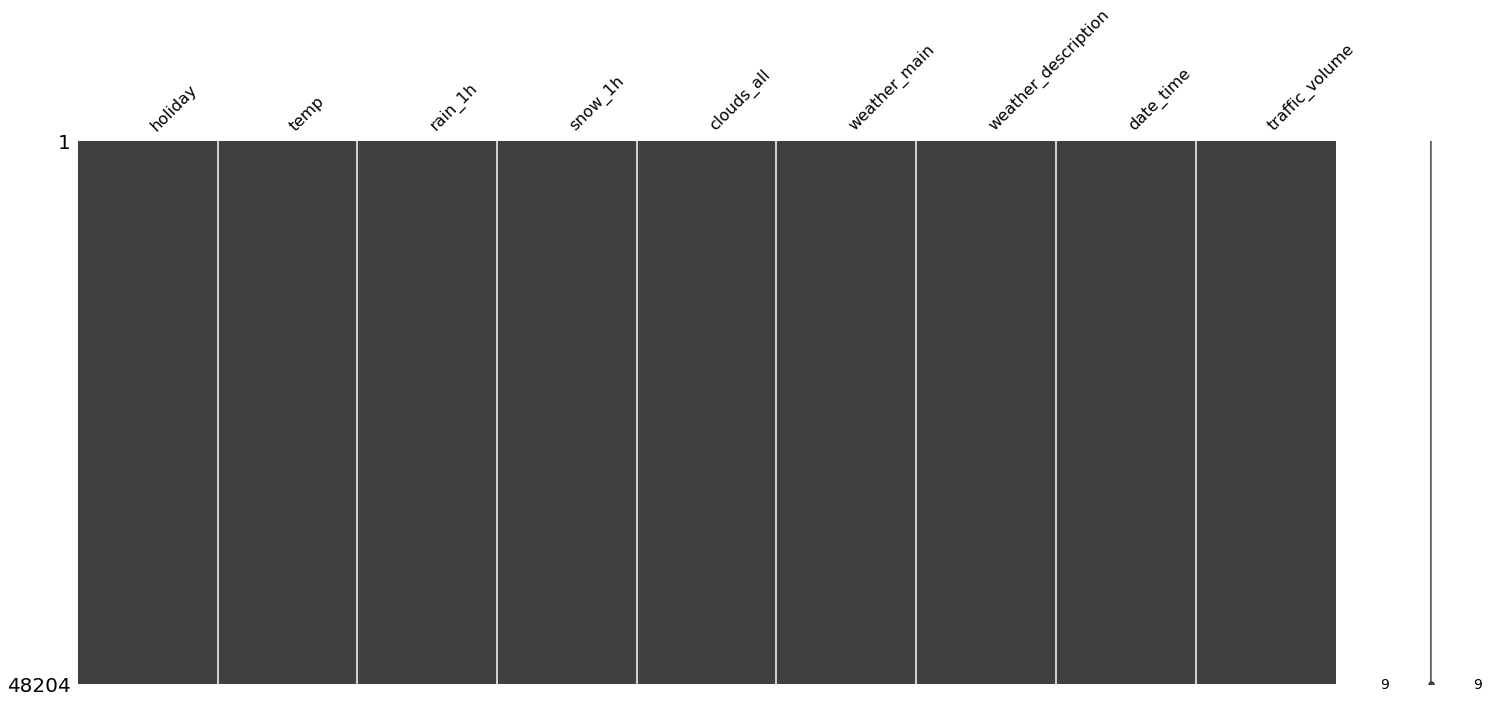

In [6]:
msno.matrix(data) #check for missing values

There are no missing values, so no need to impute anything.


##### **Correlation Plots**

In [7]:
data['holiday'].value_counts() #12 categories

None                         48143
Labor Day                        7
New Years Day                    6
Christmas Day                    6
Martin Luther King Jr Day        6
Thanksgiving Day                 6
Washingtons Birthday             5
Independence Day                 5
State Fair                       5
Columbus Day                     5
Memorial Day                     5
Veterans Day                     5
Name: holiday, dtype: int64

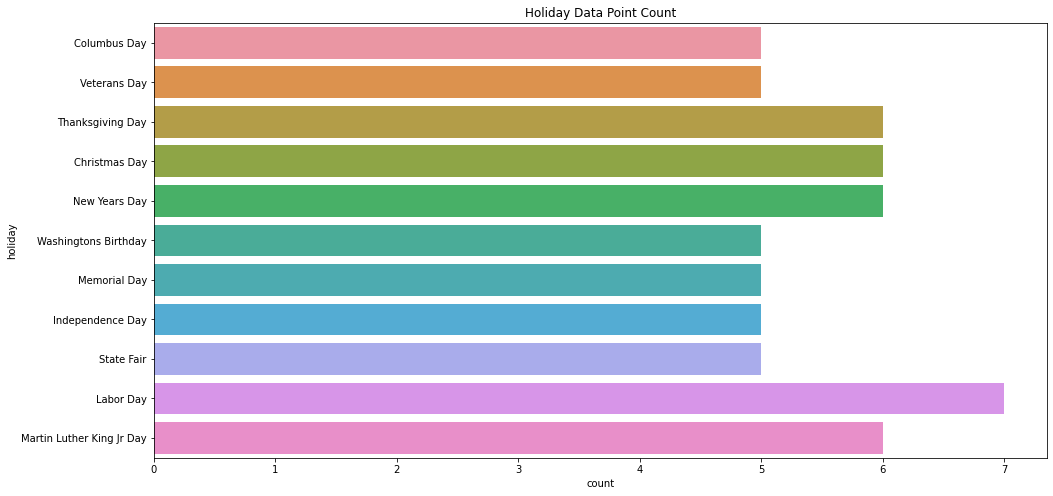

In [8]:
#check how many data points we have for each holiday

holidays = data.loc[data.holiday != 'None']
plt.figure(figsize=(16,8))
plt.title('Holiday Data Point Count')
sns.countplot(y='holiday', data= holidays)
plt.show()

There is 6 years worth of data and 24 measurements per day so, therefore, 6 years x 24 = 114 datapoints, but we only have 6 so we will need to clean this.

A table of the problem is below. Concretely, the datapoints for the holiday column are incorrect so we need to change this so that each day holds the correct holiday, see data cleaning below.

In [9]:
data[data['date_time'].str.startswith('2013-08-22')] #search for State Fair 2013

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
8575,State Fair,297.42,0.00,0.0,12,Clouds,few clouds,2013-08-22 00:00:00,661
8576,None,297.42,0.00,0.0,12,Clouds,few clouds,2013-08-22 01:00:00,385
8577,None,297.09,0.00,0.0,12,Clouds,few clouds,2013-08-22 02:00:00,302
8578,None,296.89,0.00,0.0,0,Clear,Sky is Clear,2013-08-22 03:00:00,374
8579,None,296.34,0.00,0.0,0,Clear,Sky is Clear,2013-08-22 04:00:00,871
8580,None,295.95,0.00,0.0,0,Clear,Sky is Clear,2013-08-22 05:00:00,3145
8581,None,295.45,0.00,0.0,0,Mist,mist,2013-08-22 06:00:00,6188
8582,None,295.34,0.00,0.0,0,Mist,mist,2013-08-22 07:00:00,6823
8583,None,295.74,0.00,0.0,0,Mist,mist,2013-08-22 08:00:00,4343
8584,None,296.81,0.00,0.0,32,Clouds,scattered clouds,2013-08-22 09:00:00,6063


Correlation plots with just numerical data

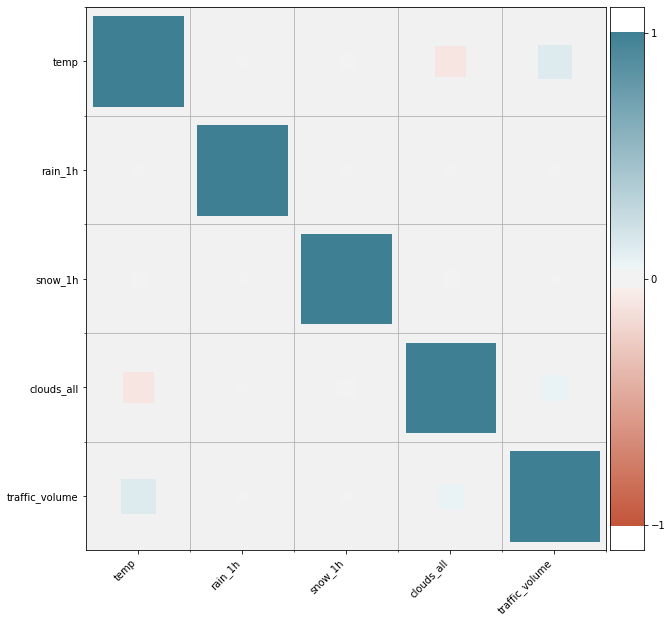

In [10]:
plt.figure(figsize=(10,10)) #explore existing correlation in the data
corrplot(data.corr(), size_scale=8000)

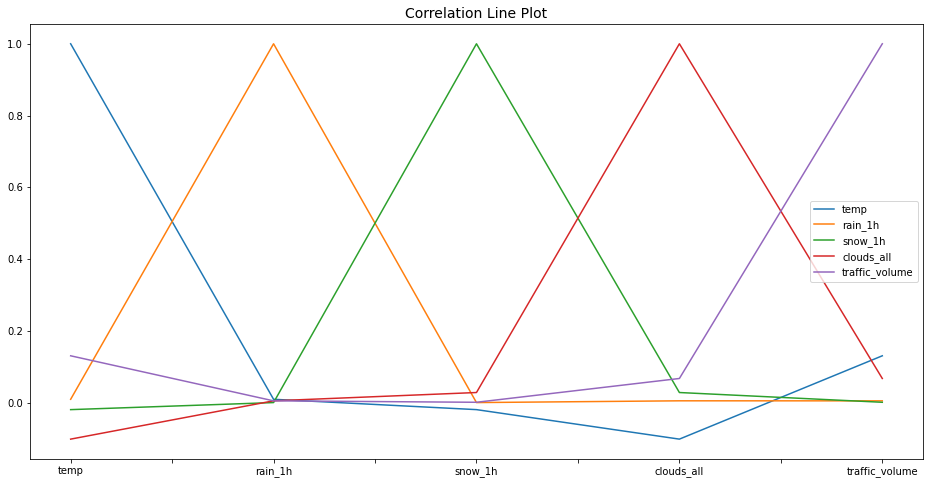

In [11]:
data.corr().plot(figsize=(16,8))
plt.title('Correlation Line Plot', fontsize=14)
plt.legend(loc='center right')

Both correlation plots show that temperature, cloud cover and traffic volume are somewhat correlated ~0.15. So I have plotted additional graphs below. While doing this, I found a few outliers. 


##### **Identifying Outliers**
By looking at the output from the describe function we can see that temperature has a minimum value of 0K. Based on my mechanical engineering background (and perhaps, general knowledge too?), this is impossible and therefore, these are outliers. We will add an imputer to our pipeline instead of removing them from the dataset.

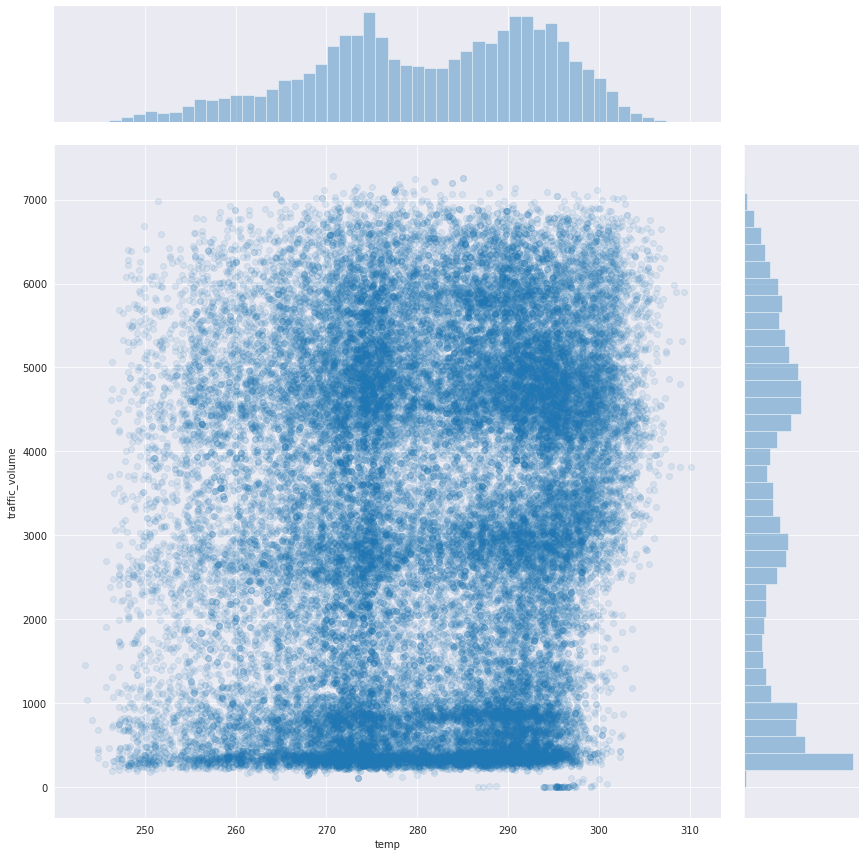

In [12]:
sns.set_style('darkgrid')
sns.jointplot(y='traffic_volume', x='temp', 
              data = data.loc[data.temp !=0], #do not plot outliers
              alpha= 0.1, height=12)
plt.show()

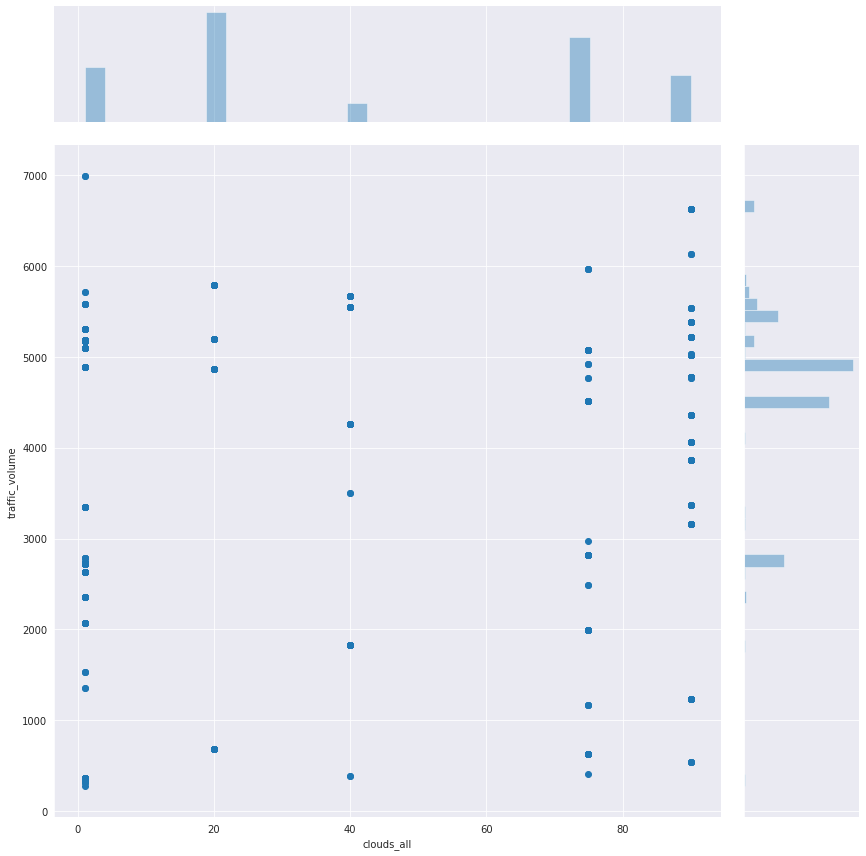

In [13]:
sns.set_style('darkgrid')
sns.jointplot(x='clouds_all', y='traffic_volume',
              data = data.loc[data.clouds_all], height=12)
plt.show()

That is interesting the spread in the percentage cloud cover seems to dominate around 5%, 20%, 40%, 75% and 90% with very few points between. Lets check that this is still a numerical feature rather than a categorical one. 



In [14]:
data['clouds_all'].value_counts().head(10)

90    16442
1     12761
75     5069
40     3993
0      1988
20     1849
64     1558
5      1094
92      776
12      273
Name: clouds_all, dtype: int64

Fortunately, there are various other values but this does warrant a check with the sensors to double check that they are calibrated properly.




#### **Weather Categories**
Moving on, lets take a look at the weather_main and weather_description categories. 

In [15]:
data['weather_main'].value_counts() #11 categories

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

*What is a squall? A sudden burst of wind. See video: https://www.youtube.com/watch?v=JKR910Dyc2c 
We will keep this is for now, if the mean absolute error does not meet our objective then we will remove this and replace it with the 'Rain' category in the hope this improves our model.*

In [16]:
data['weather_description'].value_counts() #38 Categories of weather descriptions

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto


To limit the number of features, lets remove this feature as this is similiar to the 'weather_main' category and the OneHotEncoder will 

The graphs above have already given us great insight into the data but dive into the traffic_volume column (i.e. what we are predicting). 


In [17]:
traffic_volume_mean =data['traffic_volume'].mean()
traffic_volume_mean

3259.8183553232097

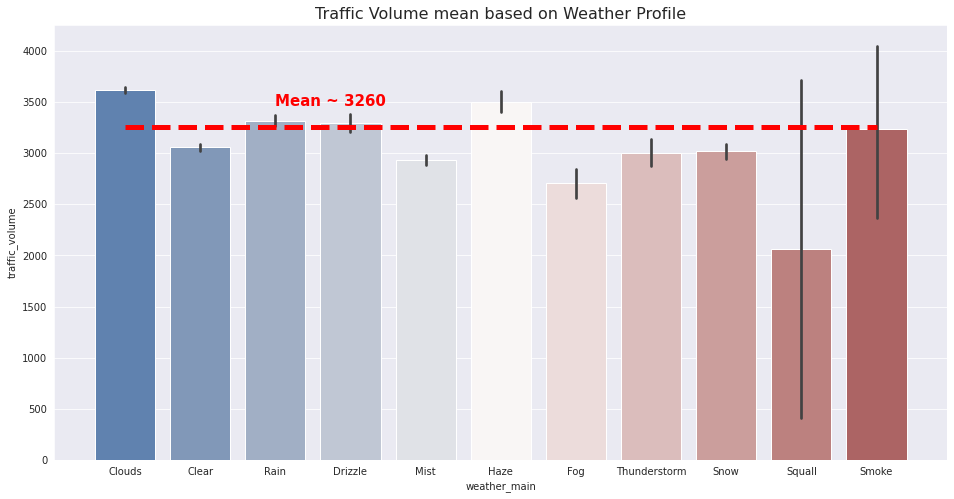

In [18]:
plt.figure(figsize=(16,8))
plt.title('Traffic Volume mean based on Weather Profile', fontsize=16)
sns.barplot(x='weather_main', y = 'traffic_volume', data = data, palette= 'vlag')
plt.plot([0,10], [traffic_volume_mean, traffic_volume_mean], 'r--', linewidth=5)
plt.annotate(xy=(2, traffic_volume_mean+200),
             s='Mean ~ {:.4g}'.format(traffic_volume_mean),
             fontsize=15, c='r', weight= 'bold')
plt.show()

In [19]:
data[data['weather_description'] == 'shower snow'] 
#take a look at the shower snow instance

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
4302,None,268.68,0.0,0.0,90,Snow,shower snow,2013-03-15 07:00:00,5664


#### **Repeat Values**

One final check, lets see if we have any repeat values and understand why this would be the case. Fortunetly, the repeat values implies that there were severe weather changes during the hour. 

In [20]:
FILT = data['date_time'].value_counts() != 1 #values that have more than 1 reading in a given hour
FILT.value_counts()

False    35130
True      5445
Name: date_time, dtype: int64

#### **Summary of Features**

It should be said that the graphs within this section do not highlight any categorical features. Once, we carry out the machine learning model we can assess the importance of these features. However, for now, lets move on to data cleaning.

We have learnt from the graphs above that there is still a lot of data cleaning required. 


To summarise what we have learnt about each feature:
1. Holiday Categorical: Categorical Feature - 12
2. Temp Average: Numerical Feature
3. Rain_1h#: Numerical Feature
4. Snow_1h: Numerical Feature
5. Clouds_all: Numerical Feature
6. Weather_main: Categorical Feature - 11
7. Weather_description: Categorical Feature - 38
8. Date_time: DateTime Object
9. Traffic_volume: Numerical Feature - y value

---

# Data Cleaning

---

From the data exploration we know that the preprocessing step will involve, the following:
1. Convert the date_time column so that it contains a date_time object.
2. Replace incorrectly labelled holiday column so that the holiday is shown throughout the day. 
3. Drop Columns
4. Replace outlier temperature values with the mean value for that month.
5. One Hot Categorical features: Holidays and Weather_main
6. StandardScaler all numerical values




#### **Convert Date_time**

This can be done by using pandas to_date_time() function on the date_time column. 

Note, all times that are at midnight get converted as a day with the time removed, for example, 2013-08-22 00:00:00 became 2013-08-22. This defeats the purpose of having on the hour predictions. Therefore, I added 1second to the time so we can keep all on the hour data.

*We need to convert the date to int so we can use them for a machine learning model.*

In [21]:
data['date_time'] = pd.to_datetime(data['date_time'],
                                   format= '%Y-%m-%d %H:%M:%S') + pd.Timedelta('1s')
data['Day_year'] = data['date_time'].dt.year
data['Day_month'] = data['date_time'].dt.month
data['Day_week'] = data['date_time'].dt.week
data['Day_day'] = data['date_time'].dt.day
data['Day_hour'] = data['date_time'].dt.hour
data['Day_dayofweek'] = data['date_time'].dt.dayofweek
data['date_string'] = data['date_time'].dt.strftime('%Y-%m-%d')
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Day_year,Day_month,Day_week,Day_day,Day_hour,Day_dayofweek,date_string
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:01,5545,2012,10,40,2,9,1,2012-10-02
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:01,4516,2012,10,40,2,10,1,2012-10-02
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:01,4767,2012,10,40,2,11,1,2012-10-02
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:01,5026,2012,10,40,2,12,1,2012-10-02
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:01,4918,2012,10,40,2,13,1,2012-10-02


#### **Replace Incorrectly labelled Holiday column**
We can use the date column so we can use it to set the holiday columns. 

In [22]:
holidays = data[data['holiday'] != 'None'][['holiday', 'date_string']].drop_duplicates(keep='first').reset_index(drop=True)
holidays 

,holiday,date_string
0,Columbus Day,2012-10-08
1,Veterans Day,2012-11-12
2,Thanksgiving Day,2012-11-22
3,Christmas Day,2012-12-25
4,New Years Day,2013-01-01
5,Washingtons Birthday,2013-02-18
6,Memorial Day,2013-05-27
7,Independence Day,2013-07-04
8,State Fair,2013-08-22
9,Labor Day,2013-09-02


#### **Outliers**

There are a few outliers within the temperature column with the recorded temperature of 0. I will replace the value with the average temperature for that month. 

In [23]:
data[data['temp'] <200] #outliers

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Day_year,Day_month,Day_week,Day_day,Day_hour,Day_dayofweek,date_string
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:01,361,2014,1,5,31,3,4,2014-01-31
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:01,734,2014,1,5,31,4,4,2014-01-31
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:01,2557,2014,1,5,31,5,4,2014-01-31
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:01,5150,2014,1,5,31,6,4,2014-01-31
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:01,291,2014,2,5,2,3,6,2014-02-02
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:01,284,2014,2,5,2,4,6,2014-02-02
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:01,434,2014,2,5,2,5,6,2014-02-02
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:01,739,2014,2,5,2,6,6,2014-02-02
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:01,962,2014,2,5,2,7,6,2014-02-02
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:01,1670,2014,2,5,2,8,6,2014-02-02


In [24]:
monthly_average = data[['temp', 'Day_month', 'Day_year']].groupby(['Day_month', 'Day_year']).mean().reset_index()
monthly_average.loc[(monthly_average['Day_month'] == 9) & (monthly_average['Day_year'] == 2018), 'temp'].iloc[0]

290.5208235294117

In [25]:
holiday_list = []
temperature_list = []

for index, row in data.iterrows():
  holiday = holidays.loc[holidays['date_string'] == row['date_string'], 'holiday']
  if holiday.empty:
    holiday_list.append('Not Holiday')
  else:
    holiday_list.append(holiday.iloc[0])
  
  average_temperature = monthly_average.loc[(monthly_average['Day_month'] == row['Day_month']) &
                                            (monthly_average['Day_year'] == row['Day_year']), 'temp']

  if row['temp'] < 200.0:
    temperature_list.append(average_temperature.iloc[0])
  else:
    temperature_list.append(row['temp'])

data['temp'] = temperature_list
data['holiday'] = holiday_list

data[data['holiday'] == 'Christmas Day']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Day_year,Day_month,Day_week,Day_day,Day_hour,Day_dayofweek,date_string
2360,Christmas Day,264.40,0.0,0.0,90,Clouds,overcast clouds,2012-12-25 00:00:01,803,2012,12,52,25,0,1,2012-12-25
2361,Christmas Day,264.52,0.0,0.0,90,Clouds,overcast clouds,2012-12-25 01:00:01,575,2012,12,52,25,1,1,2012-12-25
2362,Christmas Day,264.42,0.0,0.0,90,Clouds,overcast clouds,2012-12-25 02:00:01,352,2012,12,52,25,2,1,2012-12-25
2363,Christmas Day,264.31,0.0,0.0,90,Clouds,overcast clouds,2012-12-25 03:00:01,191,2012,12,52,25,3,1,2012-12-25
2364,Christmas Day,264.31,0.0,0.0,90,Snow,heavy snow,2012-12-25 04:00:01,125,2012,12,52,25,4,1,2012-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40079,Christmas Day,253.57,0.0,0.0,5,Clear,sky is clear,2017-12-25 19:00:01,3100,2017,12,52,25,19,0,2017-12-25
40080,Christmas Day,253.23,0.0,0.0,5,Clear,sky is clear,2017-12-25 20:00:01,2875,2017,12,52,25,20,0,2017-12-25
40081,Christmas Day,253.00,0.0,0.0,5,Clear,sky is clear,2017-12-25 21:00:01,2404,2017,12,52,25,21,0,2017-12-25
40082,Christmas Day,252.76,0.0,0.0,1,Clear,sky is clear,2017-12-25 22:00:01,1798,2017,12,52,25,22,0,2017-12-25


#### **Drop Object Columns that are no required**


In [26]:
data.drop(columns= ['date_time', 'weather_description', 'date_string'], inplace=True)

##### **Plot Holiday data**

As we have changed the holiday column we can now plot the data and observe more instances for each holiday. 


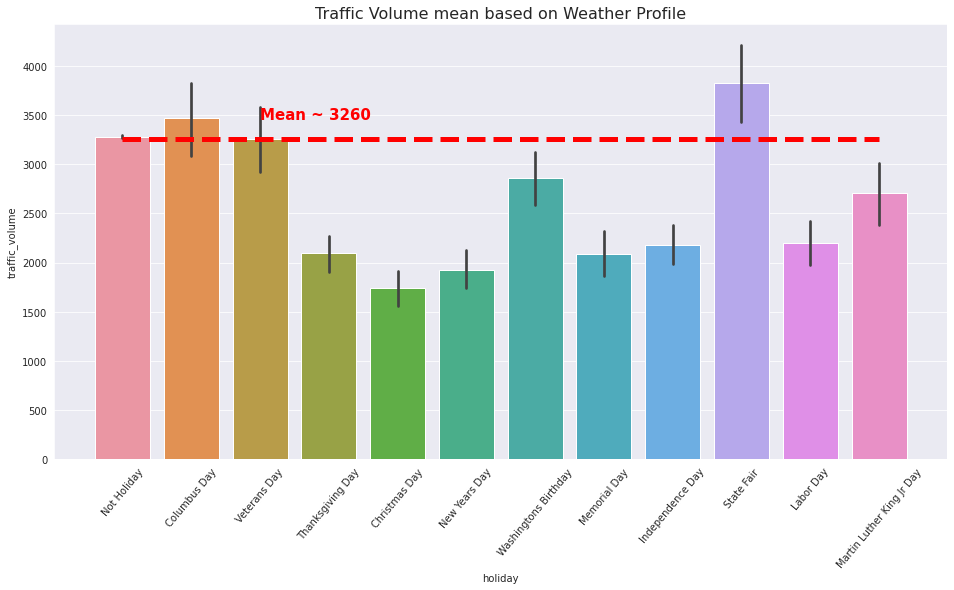

In [27]:
plt.figure(figsize=(16,8))
plt.title('Traffic Volume mean based on Weather Profile', fontsize=16)
dropped = data.drop(data[data['holiday'] == 'None'].index)
sns.barplot(x='holiday', y = 'traffic_volume', data = dropped)
plt.xticks(rotation=50)
plt.plot([0, 11], [traffic_volume_mean, traffic_volume_mean], 'r--', linewidth=5)
plt.annotate(xy=(2, traffic_volume_mean+200),
             s='Mean ~ {:.4g}'.format(traffic_volume_mean),
             fontsize=15, c='r', weight= 'bold')
plt.show()

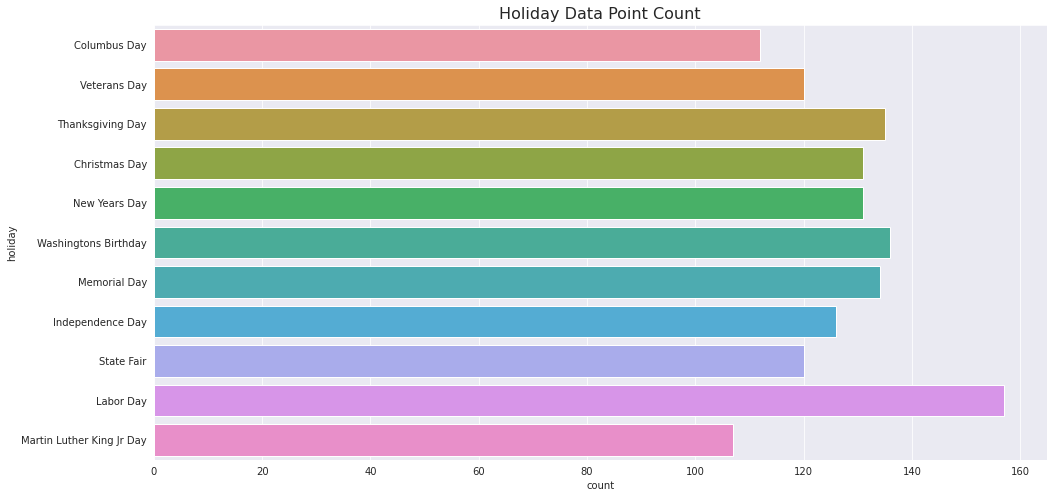

In [28]:
holidays = data.loc[data.holiday != 'Not Holiday']
plt.figure(figsize=(16,8))
plt.title('Holiday Data Point Count', fontsize=16)
sns.countplot(y='holiday', data= holidays)
plt.show()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
 7   Day_year        48204 non-null  int64  
 8   Day_month       48204 non-null  int64  
 9   Day_week        48204 non-null  int64  
 10  Day_day         48204 non-null  int64  
 11  Day_hour        48204 non-null  int64  
 12  Day_dayofweek   48204 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 4.8+ MB


---

# **Prepare for Machine Learning Algorithms**

---
Now that the data has been cleaned I can now prepare the data for machine learning algorithms. I will start by using a good practice amongst machine learning, by splitting the dataset into training, testing and validation.

Following the splitting, I will use ColumnTransformer to produce a sprase matrix - this will be a matrix with every instance containing 33 features (i.e. 10 numerical features + 12 holiday categories + 11 weather categories).

We use train_test_split to split the data and set the random state, but first remove the labels from the data set. 

In [30]:
X =data.drop(columns='traffic_volume')
y = data['traffic_volume']

In [31]:
from sklearn.model_selection import train_test_split

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y,
                                                                test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                      test_size=0.2, random_state=42)


#### **Transformation Pipelines  & Feature Scaling**

Create a numerical and categorical pipeline and use Sci-kit Learn's ColumnTranformer class. 

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
                         ('std_scaler', StandardScaler())
])
num_attribs =list(X.describe().columns)
cat_attribs = [attr for attr in X.columns if attr not in (X.describe().columns)]

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)
])
full_pipeline.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['temp', 'rain_1h', 'snow_1h', 'clouds_all',
                                  'Day_year', 'Day_month', 'Day_week',
                                  'Day_day', 'Day_hour', 'Day_dayofweek']),
                                ('cat',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
        

In [33]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_train_prepared.shape

(30850, 33)

The data is now prepared for machine learning!

---

# **Select and Train Machine Learning Models**

---
The number of features is only 33 so there is no need to use PCA, unless things are really slow. However, it may come in handy when plotting the results.

The models that I will look into are:

1. Random Forest Regressor
2. XGBoost
3. Neural Networks - Sequential

The metrics used to compare the models: 

- **Mean squared error regression loss**: test_neg_mean_squared_error

- **Coefficient of Determination**: regression score function: r2 (1.0 is best score)
- **Mean Absolute Error**: gives an indication of the difference between the forecasted value and actual value.  

The RMSE is the traffic volume per hour. For example, 300 vehicles per hour imply 5 vehicles per second. The coefficient of determination gives us the explained and unexplained variance, will be explain later. 

Once the models have been trained, I will then fine tune the best model and conclude with the model which fits the project's objective the best. 

In [34]:
X_test_prepared = full_pipeline.transform(X_test)
X_valid_prepared = full_pipeline.transform(X_valid)

#### **Random Forest** 


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error


rnd_reg = RandomForestRegressor(n_estimators= 1500, n_jobs=-1,
                                random_state=42, criterion= 'mse')

rnd_reg.fit(X_train_prepared, y_train)

scoring = ['neg_mean_squared_error', 'r2'] #coefficient of determination
forest_scores = cross_validate(rnd_reg, X_train_prepared, y_train, scoring= scoring,
                                cv=5, n_jobs=-1)

In [36]:
print("Training RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(-forest_scores['test_neg_mean_squared_error'].mean()),
                                       np.sqrt(forest_scores['test_neg_mean_squared_error'].std() * 2)))


print("Coeff of Determination: %0.2f (+/- %0.3f)" % (forest_scores['test_r2'].mean(),
                                       forest_scores['test_r2'].std() * 2))


Training RMSE: 338.74 (+/- 106.33)
Coeff of Determination: 0.97 (+/- 0.003)


##### **Analyzing Random Forest Best features**


In [37]:
cat_encoder = full_pipeline.named_transformers_['cat']
encoded_cat_attribs = [item for items in cat_encoder.categories_ for item in items]
all_attribs = num_attribs + encoded_cat_attribs
sorted(zip(rnd_reg.feature_importances_, all_attribs), reverse=True)

[(0.8272761017597889, 'Day_hour'),
 (0.108244938831374, 'Day_dayofweek'),
 (0.013094655846366298, 'temp'),
 (0.012814821642553978, 'Not Holiday'),
 (0.010727348245563439, 'Day_week'),
 (0.008364245651746035, 'Day_day'),
 (0.005034478164616957, 'Day_year'),
 (0.0026761014728657103, 'clouds_all'),
 (0.0026208199941947824, 'Day_month'),
 (0.0023233769498564798, 'rain_1h'),
 (0.0008291205425257502, 'State Fair'),
 (0.0008028469979554549, 'Fog'),
 (0.0007640409674296995, 'Clouds'),
 (0.0007085542061474938, 'Snow'),
 (0.0005378529678442348, 'Veterans Day'),
 (0.0005280821167415389, 'Columbus Day'),
 (0.0005087397994145588, 'Mist'),
 (0.0003872778191270601, 'Clear'),
 (0.0003134566716759547, 'Haze'),
 (0.00030514656462212147, 'Rain'),
 (0.00021222138516388702, 'Washingtons Birthday'),
 (0.00020006384800373963, 'Memorial Day'),
 (0.00019803390384466, 'Martin Luther King Jr Day'),
 (0.00015704160569349104, 'Thunderstorm'),
 (9.363039184689728e-05, 'Labor Day'),
 (9.090790550712072e-05, 'Drizzle

Looking at the feature importances the model was able to recognise patterns and feature importance many features. 

Lets take a look at the RMSE and coefficient of determination (R^2) for the validation data. 

In [38]:
from sklearn.metrics import mean_squared_error
y_valid_forest = rnd_reg.predict(X_valid_prepared)
print('Random Forest Regressor')
print('Validation RMSE: %0.2f' % np.sqrt(mean_squared_error(y_valid, y_valid_forest)))
print('Validation Coeff of Determination: %0.2f' % rnd_reg.score(X_valid_prepared, y_valid))

Random Forest Regressor
Validation RMSE: 317.01
Validation Coeff of Determination: 0.97


A marginal gain in performance, which shows we are not overfitting and Random Forest appears to be a good model. 

The **coefficient of determination** gives explained variance and unexplained variance. The Random Forest Regressor's coefficient of determination show that the traffic volume is explained 97% of the time and the other 3% is unexplained. This could be due to the sampling error, other variables such as limited data for rapid weather changes, or other variables that have not been included within the dataset such as local events (i.e. professional sports events).  

#### **XGBoost** 

In [39]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(objective= 'reg:squarederror', 
                       n_jobs=-1, random_state= 42,
                       n_estimators= 10000, max_depth=20) #added in because model was not converging for default values

xgb_reg.fit(X_train_prepared, y_train, eval_set= [(X_valid_prepared, y_valid)],
            early_stopping_rounds= 10, verbose=0)

y_valid_xgb = xgb_reg.predict(X_valid_prepared)
y_val_error = mean_squared_error(y_valid, y_valid_xgb)

In [40]:
print('XGBoost Regressor')
print('Validation RMSE: %0.2f' % np.sqrt(y_val_error))
print('Validation Coeff of Determination: %0.2f' % xgb_reg.score(X_valid_prepared, y_valid))

XGBoost Regressor
Validation RMSE: 283.64
Validation Coeff of Determination: 0.98


##### **Analyzing XGBoost Best features**
The XGBoost model is able to build importance to more features within the dataset but not strong relationships like the Random Forest model does.  

In [41]:
sorted(zip(xgb_reg.feature_importances_, all_attribs), reverse=True)

[(0.37228093, 'Not Holiday'),
 (0.25293243, 'Day_hour'),
 (0.13499275, 'State Fair'),
 (0.113960795, 'Memorial Day'),
 (0.071349286, 'Day_dayofweek'),
 (0.0067865495, 'Veterans Day'),
 (0.0063634473, 'New Years Day'),
 (0.0054463116, 'Washingtons Birthday'),
 (0.004712127, 'Day_week'),
 (0.0035930926, 'rain_1h'),
 (0.003246573, 'Columbus Day'),
 (0.002931356, 'Martin Luther King Jr Day'),
 (0.0026912128, 'snow_1h'),
 (0.0021484625, 'Day_day'),
 (0.0019050657, 'Independence Day'),
 (0.0017900008, 'Fog'),
 (0.0017068113, 'Day_year'),
 (0.0015571747, 'Day_month'),
 (0.0015085533, 'Labor Day'),
 (0.0012454941, 'Thanksgiving Day'),
 (0.001185053, 'Christmas Day'),
 (0.001013855, 'Snow'),
 (0.00094007334, 'Clouds'),
 (0.00070248893, 'clouds_all'),
 (0.00067362393, 'temp'),
 (0.0005252559, 'Haze'),
 (0.0005067389, 'Thunderstorm'),
 (0.00041699002, 'Clear'),
 (0.0003680622, 'Mist'),
 (0.00020668557, 'Rain'),
 (0.00012250312, 'Drizzle'),
 (0.00010421815, 'Smoke'),
 (8.5978136e-05, 'Squall')]

Overall, XGBoost model performed better than the Random Forest.

Both models give an RSME score of around 280 to 320

#### **Neural Network** 
Based on previous datasets, I believe a neural network with 4 hidden layers is enough. Latest research shows that Scaled Exponential Linear Unit (elu) and LeCun normal initialization as the initializer should be a good starting point. 

##### **Import TensorFlow and Build Neural Network**
For the ELU activation function, I used He's normal initialization. I have also applied dropout just below the last layer to avoid overfitting and act as a regularizer.

###### ***Other deep learning models experiemented with include***:
1. SELU activation function with LeCun's initialization. I had not much luck with it compared to ELU. Below is the data preparation cell for SELU. 

2. I have used Nadam here (and with the SELU model) but RMSProp worked well too. Both converged very fast and not much difference in performance was observed.

3. AlphaDropout prior to the last hidden layer with a rate of 0.2 was implemented for the SELU model. For the ELU model I started with a rate of 0.2 initially but the 0.25 generalized a bit better.  

4. I started with a small number of neurons per layer and 1 hidden layer. I gradually increased the number of hidden layers as recommended by Vincent Vanhoucke (Google scientist).

4. I opted for a rule of thumb network architecture. 

In [42]:
#used for selu as a preparation step
pixel_means = X_train_prepared.mean(axis=0, keepdims=True)
pixel_stds = X_train_prepared.std(axis=0, keepdims=True)
X_train_scaled = (X_train_prepared - pixel_means) / pixel_stds
X_valid_scaled = (X_valid_prepared - pixel_means) / pixel_stds
X_test_scaled = (X_test_prepared - pixel_means) / pixel_stds

In [43]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [44]:
input_shape= X_train_prepared.shape[1:]

model = keras.models.Sequential()
model.add(keras.layers.Dense(300, input_shape=input_shape,
                               activation= 'elu',
                               kernel_initializer= 'he_normal'))

#add multiple hidden layers into the deep network
for _ in range(5):
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(100,
                               activation= 'elu',
                               kernel_initializer= 'he_normal'))

model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(100,
                               activation= 'elu',
                               kernel_initializer= 'he_normal'))

model.add(keras.layers.Dense(1))                         

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               10200     
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

##### **Compile and Build 1Cycle Learning Rate Scheduler**

Using Nadam optimizer and 1Cycle as the learning rate to speed up convergence.  

In [46]:
model.compile(loss= 'mse',
              optimizer= 'nadam',
              metrics= ['mse','mae'])

###### **1 Cycle Class**
*The 1 Cycle class below was inspired by Aurélien Géron's Hands on Machine Learning book.*

In [47]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

###### **Identify 1Cycle 1Cycle Learning Rate**


242/242 [==============================] - 2s 6ms/step - loss: 8964431872.0000 - mse: 8964431872.0000 - mae: 7085.3779


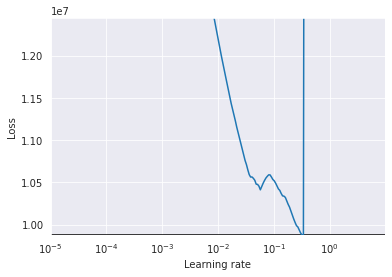

In [48]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_prepared, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

The above plot shows that the learning rate should be just before the loss diverges. So for the learning rate selected will start at around this point.

In [49]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

##### **Model's callbacks**


In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_check_cb = keras.callbacks.ModelCheckpoint('traffic_volume_model.h5',
                                                 save_best_only= True)
#hyperparameters
batch_size = 32
n_epochs = 100
max_rate= 0.09

onecycle_cb = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=max_rate)
callbacks = [early_stopping_cb, model_check_cb, onecycle_cb]

##### **Train Model**

In [51]:
history = model.fit(X_train_prepared, y_train, epochs= n_epochs,
          validation_data= (X_valid_prepared, y_valid),
          callbacks= [callbacks])

Epoch 1/100
965/965 [==============================] - 4s 4ms/step - loss: 3893618.5000 - mse: 3893618.5000 - mae: 1358.9524 - val_loss: 1283349.3750 - val_mse: 1283349.3750 - val_mae: 801.3258
Epoch 2/100
965/965 [==============================] - 4s 4ms/step - loss: 1139113.6250 - mse: 1139113.6250 - mae: 770.8885 - val_loss: 879122.0000 - val_mse: 879122.0000 - val_mae: 697.2789
Epoch 3/100
965/965 [==============================] - 4s 4ms/step - loss: 1024861.6250 - mse: 1024861.6250 - mae: 727.2897 - val_loss: 930896.6250 - val_mse: 930896.6250 - val_mae: 764.6646
Epoch 4/100
965/965 [==============================] - 4s 4ms/step - loss: 937966.9375 - mse: 937966.9375 - mae: 690.1784 - val_loss: 440106.6562 - val_mse: 440106.6562 - val_mae: 479.2166
Epoch 5/100
965/965 [==============================] - 4s 4ms/step - loss: 880513.8125 - mse: 880513.8125 - mae: 666.8113 - val_loss: 1370069.5000 - val_mse: 1370069.5000 - val_mae: 945.7559
Epoch 6/100
965/965 [=======================

Overall, not a great model and the validation results are awful. I experiemented with many learning rates, activation functions, initializations, architectures and dropout rates to name a few. However, the convegernce of the model with only 16 epochs is appealing. 



---

# **Fine Tune Machine Learning Model**

---

The best model was XGBoost so using Randomized Grid Search to find the best hyperparameters before testing. 

I searched for various estimators, max_depths and learning rates. Searching the number of estimators from 3,000 to 30,000, ,max depths from 10 to 40 and learning rate from 0.03 to 0.3. I have limited the number of searched parameters to allow for code repeatability.  

In [52]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(random_state=42, objective= 'reg:squarederror')

param_grid = {'n_estimators': [300, 500,],
              'max_depth': [20, 30],
              'learning_rate': [0.1, 0.3]}

xgb_model = RandomizedSearchCV(estimator= xgb, param_distributions= param_grid,
                               random_state= 42, cv=3,
                               scoring= 'neg_mean_squared_error',
                               )

In [53]:
xgb_model.fit(X_train_prepared, y_train, eval_set= [(X_valid_prepared, y_valid)],
            early_stopping_rounds= 5, verbose=1)

[0]	validation_0-rmse:3424.42
Will train until validation_0-rmse hasn't improved in 5 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[1]	validation_0-rmse:3088.65
[2]	validation_0-rmse:2786.94
[3]	validation_0-rmse:2515.61
[4]	validation_0-rmse:2272.26
[5]	validation_0-rmse:2053.56
[6]	validation_0-rmse:1857.31
[7]	validation_0-rmse:1681.4
[8]	validation_0-rmse:1523.29
[9]	validation_0-rmse:1381.95
[10]	validation_0-rmse:1255.26
[11]	validation_0-rmse:1142.2
[12]	validation_0-rmse:1040.93
[13]	validation_0-rmse:951.054
[14]	validation_0-rmse:871.256
[15]	validation_0-rmse:800.572
[16]	validation_0-rmse:738.2
[17]	validation_0-rmse:682.397
[18]	validation_0-rmse:633.22
[19]	validation_0-rmse:590.356
[20]	validation_0-rmse:552.127
[21]	validation_0-rmse:519.377
[22]	validation_0-rmse:490.64
[23]	validation_0-rmse:466.351
[24]	validation_0-rmse:444.68
[25]	validation_0-rmse:426.664
[26]	validation_0-rmse:410.86
[27]	validation_0-rmse:397.07
[28]	validation_0-rmse:384.99
[29]	validation_0-rmse:374.956
[30]	validation_0-rmse:366.707
[31]	validation_0-rmse:359.105
[32]	validation_0-rmse:353.074
[33]	validation_0-rmse:347.

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                           

In [54]:
print("Best parameters found: ",xgb_model.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_model.best_score_)))

Best parameters found:  {'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1}
Lowest RMSE found:  311.6981658000788


In [55]:
y_test_pred = xgb_model.predict(X_test_prepared)
        
print('XGBoost Regressor')
print('Validation RMSE: %0.2f' % np.sqrt(mean_squared_error(y_test_pred, y_test)))

XGBoost Regressor
Validation RMSE: 286.20


---

# **Plotting Multidimensional Data**

---
Plotting the multidimensional data to observe clusters and patterns. 

In [56]:
X_prepared = full_pipeline.transform(X) #plot all data
X_prepared.shape

(48204, 33)

In [57]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components= 2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_prepared)

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_prepared, y)
X_reduced_lda = lda.transform(X_prepared)

In [59]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_prepared)

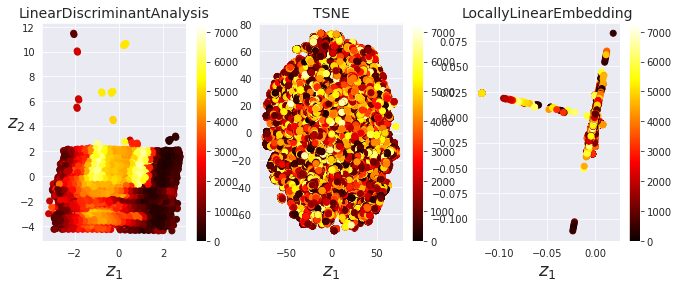

In [60]:
titles = ['LinearDiscriminantAnalysis', "TSNE", "LocallyLinearEmbedding"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_lda, X_reduced_tsne, X_reduced_lle)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.colorbar()
plt.show()

It appears that the Linear Discriminant Analysis gives a clearer picture, while TSNE groups instances together and LLE slices the instances into 2 linear planes. 

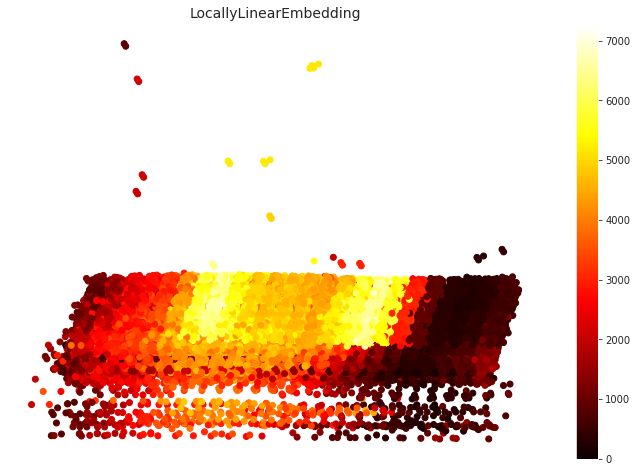

In [61]:
plt.figure(figsize=(12,8))
plt.title(title, fontsize=14)
plt.scatter(X_reduced_lda[:, 0], X_reduced_lda[:, 1], c=y, cmap=plt.cm.hot)
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show()


Locally Linear Embedding provided the best visual dimensionality reduction plot. We can see that larger traffic volumes are grouped together. It may be worth labelling these and identifying patterns, however, for now, as the objectives have been met the project can be concluded. 

There are also a few outliers that are different. It would interesting to understand what these points are and why they are not within the cluster.



---
# **Conclusion**
---


The project's objective was to identify whether traffic volume is affected by public holiday and weather. This has been proven through plots and the feature analysis within the project.

The machine learning model selected was the XGBoost Regressor, which predicted traffic volume with a RMSE of ~280 and coefficient of determination of 98%. Greatly surpassing the objectives.

The random forest and the deep neural network took significantly longer to converge to their solutions. Whereas, the XGBoost model appears to be the overall winner in terms of prediction accuracy and wall time. This will make deployment easier and allow for easier retraining when the model begins to rot. 